# Demo SEA data calculations
This demonstrates the use of low-level routines to replicate signal analysis performed by SEA. The analysis parameters are close, but not identical.

### Generate fake data

In [1]:
from edge_analysis.io import simulated_awgn

duration = 4
fs = 14e6
analysis_bandwidth = 10e6

raw_iq = simulated_awgn(duration, fs)

### Analysis bandpass filter

In [2]:
from edge_analysis import channel_analysis
from scipy import signal

sos = channel_analysis.generate_iir_lpf(
    rp_dB=0.1,
    rs_dB=70,
    cutoff_Hz=analysis_bandwidth/2,
    width_Hz=250e3,
    fs = fs,
).astype('float32')

%timeit -n1 -r1 signal.sosfilt(sos, raw_iq)
iq = signal.sosfilt(sos, raw_iq)

928 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Channel power time-series

In [3]:
import iqwaveform
from edge_analysis import channel_analysis

detector_period = 10e-3

pvt = channel_analysis.power_time_series(
    iq, fs=fs, analysis_bandwidth=analysis_bandwidth, detector_period=detector_period, detectors=('rms', 'peak')
)

%timeit -n1 -r1 channel_analysis.power_time_series(iq, fs=fs, analysis_bandwidth=analysis_bandwidth, detector_period=detector_period, detectors=('rms', 'peak'))

402 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


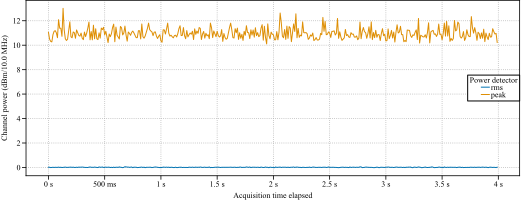

In [4]:
from iqwaveform import powtodB
from iqwaveform.env import set_caption
from matplotlib import pyplot as plt
import numpy as np
from edge_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [5]:
from iqwaveform.power_analysis import iq_to_cyclic_power

cyclic_power_resolution = 1e-3/14/4

%timeit -n1 -r1 channel_analysis.cyclic_channel_power(\
    iq,\
    fs=fs,\
    analysis_bandwidth=analysis_bandwidth,\
    cyclic_period=detector_period,\
    detector_period=cyclic_power_resolution,\
    detectors=pvt.power_detector.values,\
    cyclic_statistics=('min', 'mean', 'max')\
)

cyclic_power = channel_analysis.cyclic_channel_power(
    iq,
    fs=fs,
    analysis_bandwidth=analysis_bandwidth,
    cyclic_period=detector_period,
    detector_period=cyclic_power_resolution,
    detectors=pvt.power_detector.values,
    cyclic_statistics=('min', 'mean', 'max')
)

408 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


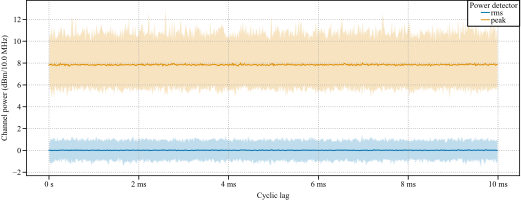

In [6]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [7]:
import importlib
channel_analysis = importlib.reload(channel_analysis)
frequency_resolution = 16e3
spectrum_quantiles = [0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999,1]

%timeit -n1 -r1 channel_analysis.persistence_spectrum(iq, fs=fs, window='flattop', fres=frequency_resolution, quantiles=spectrum_quantiles)
spectrum = channel_analysis.persistence_spectrum(iq, fs=fs, window='flattop', fres=frequency_resolution, quantiles=spectrum_quantiles)

1.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


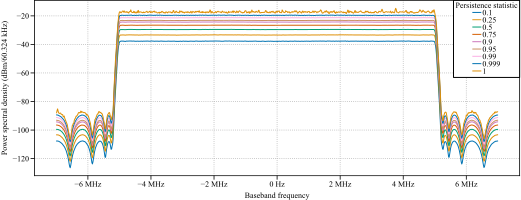

In [8]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax);
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

### Amplitude Probability Distribution

In [9]:
apd_bins = dict(power_low=-40, power_high=15, power_count=55*4+1)

%timeit -n1 -r1 channel_analysis.amplitude_probability_distribution(iq, analysis_bandwidth=analysis_bandwidth, **apd_bins)
apd = channel_analysis.amplitude_probability_distribution(iq, analysis_bandwidth=analysis_bandwidth, **apd_bins)

2.56 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


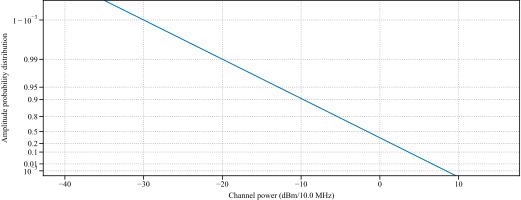

In [31]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, major_ticks=16, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Merge into a single dataset

In [30]:
import xarray as xr

ds = xr.Dataset(
    {pvt.name: pvt, cyclic_power.name: cyclic_power, apd.name: apd, spectrum.name: spectrum},
    attrs = {
        'fs': pvt.attrs['fs'],
        'analysis_bandwidth': pvt.attrs['analysis_bandwidth']
    }
)

ds

<xarray.Dataset>
Dimensions:                             (power_detector: 2, time_elapsed: 400,
                                         cyclic_statistic: 3, cyclic_lag: 560,
                                         channel_power: 221,
                                         baseband_frequency: 875,
                                         persistence_statistic: 9)
Coordinates:
  * power_detector                      (power_detector) <U4 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 0.0 0.01 ... 3.99
  * cyclic_statistic                    (cyclic_statistic) <U4 'min' ... 'max'
  * cyclic_lag                          (cyclic_lag) float64 0.0 ... 0.009982
  * channel_power                       (channel_power) float32 -40.0 ... 15.0
  * baseband_frequency                  (baseband_frequency) float64 -6.992e+...
  * persistence_statistic               (persistence_statistic) <U5 '0.1' ......
Data variables:
    power_time_series                   (power_detector, time_elapsed) float64 ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float64 ...
    amplitude_probability_distribution  (channel_power) float64 0.9999 ... 0.0
    persistence_spectrum                (baseband_frequency, persistence_statistic) float64 ...
Attributes:
    fs:                  14000000.0
    analysis_bandwidth:  10000000.0